# Final Notebook 1: Food Access in LA County
## Group Members: Madi Hamilton, Jessica Fay, Meaghan Woody, Branden Bohrnsen
### UP221 Winter 2024

### Description
**Research Question:** Are there geographic disparities trends in food insecurity in Los Angeles County?

**Notebook purpose:** Prepare data for creating maps

**Data sources:**
1. USC Neighborhood Data for Social Change
2. U.S. Census Bureau - American Community Survey 2016-2020
3. U.S. Census Tracts 2020
4. Grocery Store Walkability

### Import Libraries

In [21]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from libpysal.weights import Queen
import esda
from esda.moran import Moran, Moran_Local
import contextily as ctx
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation
import libpysal as lps
import matplotlib.pyplot as plt
import plotly.express as px
from shapely import wkt
from shapely.wkt import loads
import branca.colormap as cm
import folium

import numpy as np
import networkx as nx
import osmnx as ox
import contextily as ctx
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import plotly.express as px
from sodapy import Socrata
import mapclassify
from shapely.geometry import Point
import seaborn as sns

### Create merged dataset with variables and geometry

In [3]:
# Import merged dataset for USC and Census variables
food=pd.read_csv('finaldata_0303.csv')
food.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4910 entries, 0 to 4909
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   geoid20_x                          4910 non-null   object 
 1   CT20                               4910 non-null   object 
 2   FIPS_census                        4910 non-null   float64
 3   tract                              4910 non-null   float64
 4   ShapeSTArea                        4910 non-null   float64
 5   ShapeSTLength                      4908 non-null   float64
 6   geometry_x                         4906 non-null   object 
 7   % Hispanic or Latino               4910 non-null   int64  
 8   % Not a Citizen                    4910 non-null   int64  
 9   % Unemployed                       4910 non-null   int64  
 10  Population Density (Per Sq. Mile)  4910 non-null   int64  
 11  Median Household Income            4910 non-null   int64

In [6]:
# Load in tract shape file
tracts = gpd.read_file('tl_2020_06_tract.shp')
tracts['geoid20_x']=tracts.TRACTCE
tracts['COUNTYFP'].unique()
#filterto LA County census tracts
latracts = tracts.query("COUNTYFP == '037'")

# Conditionally delete rows where hispanic % is outlier
new = food[food['% Hispanic or Latino'] <= 100]

In [7]:
# Merging the data
tracts_census= latracts.merge(new,on="geoid20_x")

In [8]:
# Export DataFrame to CSV
tracts_census.to_csv('merged_data_jf.csv', index=False)

## Create new variables for analysis

In [9]:
# Create low access percent variable
a = food['lowaccess_count']
b =food['denom_total_pop']
food['lowaccess_pct']=round((a/b)*100)

In [10]:
# Create Food Insecurity Index 
# Create a Natural Breaks classifier
classifier = mapclassify.NaturalBreaks.make(k=5)

# Age score
tracts_census['age_pct_score'] = tracts_census[['Percent 65 years and over']].apply(classifier)
tracts_census[['Percent 65 years and over', 'age_pct_score']].head()

# Hispanic score
tracts_census['hisp_pct_score'] = tracts_census[['% Hispanic or Latino']].apply(classifier)
tracts_census[['% Hispanic or Latino', 'hisp_pct_score']].head()

# Unemployment score
tracts_census['emp_pct_score'] = tracts_census[['% Unemployed']].apply(classifier)
tracts_census[['% Unemployed', 'emp_pct_score']].head()

# Food Index: Age + Hispanic + Unemployment scores 
tracts_census['priority_index'] = tracts_census['age_pct_score']+tracts_census['hisp_pct_score']+tracts_census['emp_pct_score']

### Preparing Folium Map

In [14]:
# Import new dataset with fixed missing variables imputed using R for mapping purposes
df = pd.read_csv("merged_MAR16.csv")
gdf = gpd.GeoDataFrame(df, geometry=df['wkt'].apply(loads))
gdf.set_crs(epsg=3857, inplace=True)

gdf = gdf.dropna()

invalid_geometries = gdf[~gdf.is_valid]
print(f"Found {len(invalid_geometries)} invalid geometries")
gdf['geometry'] = gdf.geometry.buffer(0)

# Prep variables
gdf['snap_rate'] = gdf['snap_rate'].astype(float)
gdf['chd_pct'] = gdf['chd_pct'].astype(float)
gdf['lowaccess_pct'] = gdf['lowaccess_pct'].astype(float)
gdf['lowaccess_li_pct'] = gdf['lowaccess_li_pct'].astype(float)
gdf['snap_rate'] = gdf['snap_rate'].astype(float)
gdf['total_pop'] = gdf['total_pop'].astype(int)

gdf['centroid'] = gdf.geometry.centroid
centroids_geo = gdf['centroid'].to_crs(epsg=4326)


gdf['longitude'] = centroids_geo.x
gdf['latitude'] = centroids_geo.y

gdf = gdf[["geometry", "snap_rate", "chd_pct", "lowaccess_pct", "lowaccess_li_pct", "geoid20", "SPA_NAME"]]

Found 188 invalid geometries


### Preparing Walksheds

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 5 entries, 4843 to 4012
Data columns (total 44 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   STATEFP                            5 non-null      object  
 1   COUNTYFP                           5 non-null      object  
 2   TRACTCE                            5 non-null      object  
 3   GEOID                              5 non-null      object  
 4   NAME                               5 non-null      object  
 5   NAMELSAD                           5 non-null      object  
 6   MTFCC                              5 non-null      object  
 7   FUNCSTAT                           5 non-null      object  
 8   ALAND                              5 non-null      int64   
 9   AWATER                             5 non-null      int64   
 10  INTPTLAT                           5 non-null      object  
 11  INTPTLON                           5 non

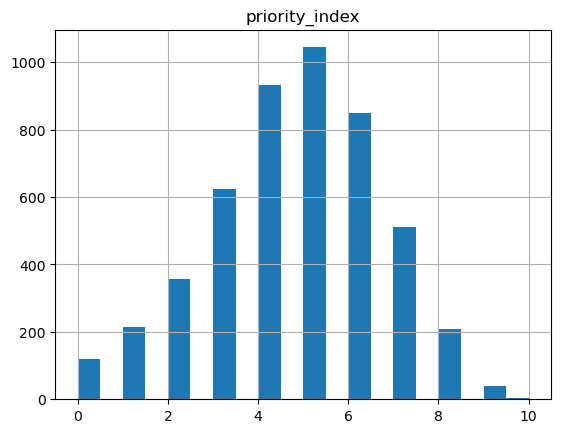

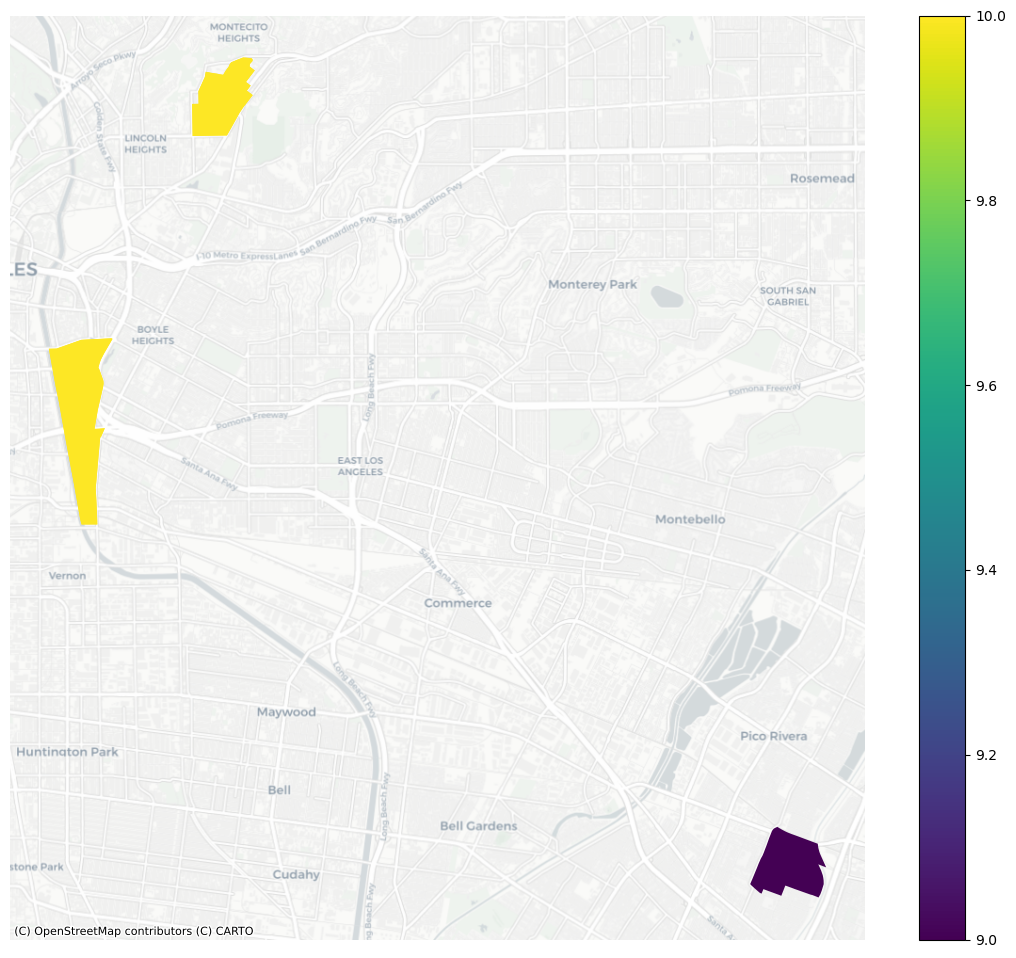

In [15]:
# Creating Subset of Census Tracts
merged_index = tracts_census.sort_values(by='priority_index', ascending=False)
merged_index.hist('priority_index',bins=20)
merged_index = merged_index.head(5)
merged_index = merged_index.to_crs('EPSG:6423')
ax = merged_index.plot(column='priority_index',legend=True,figsize=(14,12), missing_kwds={'color':'lightgrey'})
ax.set_axis_off()
ctx.add_basemap(ax,crs=6423,
               source=ctx.providers.CartoDB.Positron)
merged_index.info()


4843    POLYGON ((1978813.251 561092.945, 1978853.055 ...
4842    POLYGON ((1978813.251 561092.945, 1978853.055 ...
3034    POLYGON ((1980278.199 564192.804, 1980281.395 ...
3035    POLYGON ((1980278.199 564192.804, 1980281.395 ...
4012    POLYGON ((1989664.411 550986.524, 1989657.234 ...
dtype: geometry

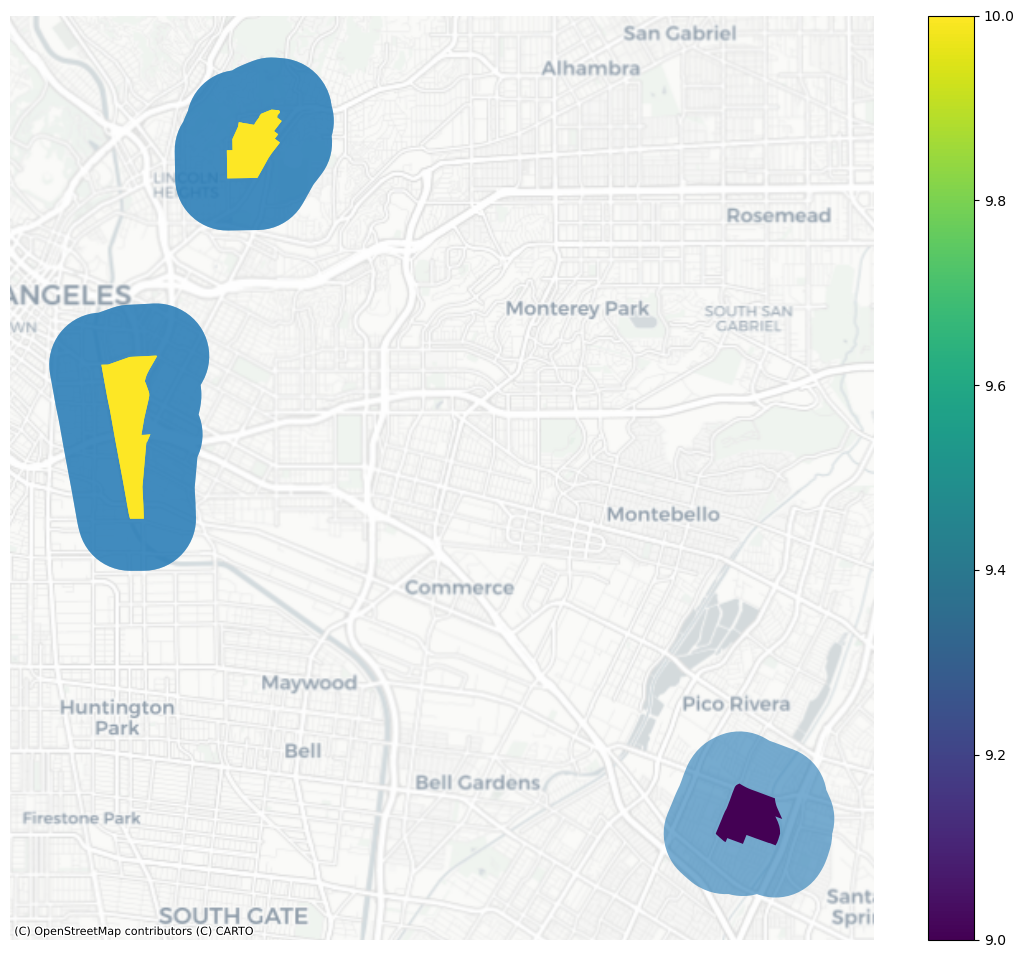

In [17]:
# Need to create a buffer around census tracts, because no grocery stores fall within their borders
# Creating a buffer around the high priority census tracts
index_buff = merged_index.buffer(1000)

ax = index_buff.plot(figsize=(14,12),alpha=0.6)
ax.set_axis_off()
merged_index.plot(ax=ax,column='priority_index',legend=True,figsize=(14,12), missing_kwds={'color':'lightgrey'})
ctx.add_basemap(ax,crs=6423,
               source=ctx.providers.CartoDB.Positron)
index_buff

In [ ]:
# Import grocery store data
grocery = gpd.read_file('cleanedgrocery.csv')
grocery = gpd.GeoDataFrame(grocery, 
                         crs='EPSG:4326',
                         geometry=gpd.points_from_xy(grocery.Longitude, grocery.Latitude))
grocery.info()
grocery = grocery.to_crs('epsg:6423')

# Create clipped areas 
ax = grocery.plot(zorder=5)
latracts.plot(ax=ax,zorder=2,cmap='Greens')
ctx.add_basemap(ax,crs=6423,
               source=ctx.providers.CartoDB.Positron)

grocery_clip = gpd.clip(grocery,index_buff)
grocery_clip = grocery_clip.reset_index()

grocery_clip.info(verbose=True,show_counts=True)

grocery_buff = grocery_clip.buffer(0.02)

# Create buffers
grocery_buff = grocery_clip.buffer(0.02)
ax = grocery_buff.plot(figsize=(14,12),alpha = 0.5, zorder=6)
ax.set_axis_off()
tracts_census.plot(ax=ax,figsize=(14,12),color='#929591',missing_kwds={'color':'lightgrey'},zorder=2)
merged_index.plot(ax=ax,column='priority_index',legend=True,figsize=(14,12), missing_kwds={'color':'lightgrey'},zorder=8)
grocery_clip.plot(ax=ax,zorder=10)
ctx.add_basemap(ax,crs=6423,
               source=ctx.providers.CartoDB.Positron)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1870 entries, 0 to 1869
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   field_1             1870 non-null   object  
 1   Record ID           1870 non-null   object  
 2   Store Name          1870 non-null   object  
 3   Store Type          1870 non-null   object  
 4   Street Number       1870 non-null   object  
 5   Street Name         1870 non-null   object  
 6   Additional Address  1870 non-null   object  
 7   City                1870 non-null   object  
 8   State               1870 non-null   object  
 9   Zip Code            1870 non-null   object  
 10  Zip4                1870 non-null   object  
 11  County              1870 non-null   object  
 12  Latitude            1870 non-null   object  
 13  Longitude           1870 non-null   object  
 14  Authorization Date  1870 non-null   object  
 15  End Date            1870 non-n

In [ ]:
# Save geometry for isochrones
grocery_clip = grocery_clip.to_crs('epsg:4326')

# Extract x & y coordinates of projection for calculation within loop.
grocery_clip['Longitude'], grocery_clip['Latitude']=[grocery_clip.geometry.x,grocery_clip.geometry.y]

# Create a geodataframe to store isochrones.
isochrones_all = gpd.GeoDataFrame({'time': [99], 'geometry': [Point(1, 2)]}, crs="EPSG:4326")

# Now, loop through each grocery store to create the isochrones around the grocery store and then append these isochrones to the list.
for index, row in grocery_clip.iterrows():
    # Download the street network surrounding the grocery store.
    G = ox.graph_from_point([grocery_clip.loc[index,'Latitude'],grocery_clip.loc[index,'Longitude']], network_type='walk', dist = 2000)

    # Project this street network data so that measurements are in meters.
    G = ox.project_graph(G, to_crs='epsg:4326')

    # Convert nodes and edges to geodataframes
    gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

    # Use osmnx's distance.nearest_nodes command to get the id for the nearest node to the grocery store. 
    center_node = ox.distance.nearest_nodes(G,Y=grocery_clip.loc[index,'Latitude'],X=grocery_clip.loc[index,'Longitude'])

    # Create a new column, calculate the time it takes to travel that edge
    gdf_edges['walk_time'] = gdf_edges['length']/80.4672

    # loop through each trip time.
    for time in [15,10,5]:

        # For each trip time, create an egograph of nodes that fall within that time
        subgraph = nx.ego_graph(G, center_node, radius=time)

        # For each of those nodes, update the gdf_nodes dataframe and assign it with its associated time
        for node in subgraph.nodes():
                gdf_nodes.loc[node,'time'] = time

    # Create polygon containing all nodes within each time (first dissolve then create a convex hull).
    isochrones = gdf_nodes.dissolve(by = "time").convex_hull.reset_index(name='geometry')
    
    # Append these results to our growing list of isochrones.
    isochrones_all = pd.concat([isochrones_all,isochrones])
walkbuffers_index=isochrones_all.iloc[1:]

In [ ]:
# Dissolve separate walksheds to create single geometry with all areas within each time.
walksheds_index=walkbuffers_index.dissolve(by = "time").reset_index().sort_values(by='time',ascending=False)

# Saving walkshed for the top 10 census tracts of the food insecurity index
walksheds_index.to_file('grocery_walksheds_index.geojson')
walksheds_index.info()

walksheds_index = walksheds_index.to_crs('epsg:6423')
countyboundary = gpd.read_file('data/County_Boundary.geojson')
countyboundary.crs

countyboundary = countyboundary.to_crs('epsg:6423')
countyboundary